<a href="https://colab.research.google.com/github/kina5596/app2/blob/main/osm2neo4j_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install folium
!pip install scikit-learn
!pip install scipy
!pip install osmnx==1.2
!pip install py2neo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of geopandas to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 50.5 MB/s eta 0:00:00
  Attempting uninstall: Shapely
    Found existing installation: shapely 2.0.6
    Uninstalling shapely-2.0.6:
      Successfully uninstalled shapely-2.0.6
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalle

In [ ]:
import folium
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
from sklearn import *
from py2neo import Graph, Node, Relationship

In [ ]:
# ジオコーディングする場合
# lat, lon = ox.geocoder.geocode("仁科漁港")


# 事前定義する場合
# lat, lon = 34.812764, 138.826198

# print(f"lat={lat} lon={lon}")

In [ ]:
# 西伊豆町の全てのタイプの道路を Open Street Map のデータから取得
G = ox.graph.graph_from_place("Nishiizu, Shizuoka, Japan", network_type="all_private")

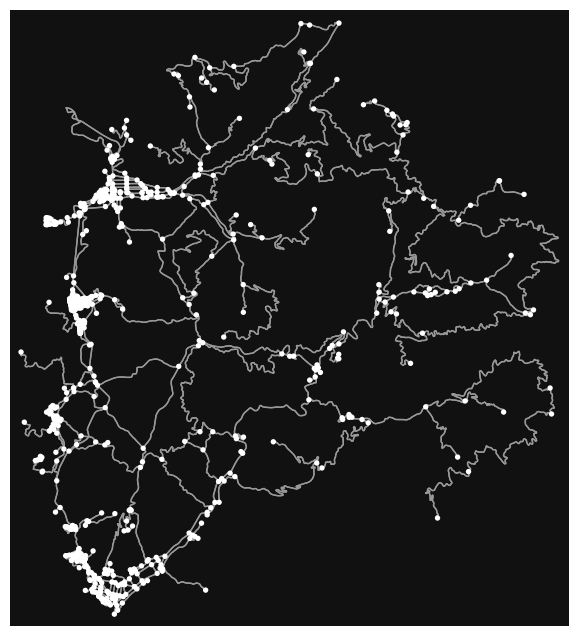

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# グラフを描画
ox.plot_graph(G)

In [ ]:
# Neo4j のサーバに接続 (neo4j-bosai-1)
graph_db = Graph("neo4j://35.200.46.163:7687", auth=("neo4j", "mtzkBosai1"))

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# Road のノードについて、ユニークであるべきとする制約条件を定義
constraint_query = """
CREATE CONSTRAINT IF NOT EXISTS
FOR (n:Road)
REQUIRE n.id IS UNIQUE
"""
graph_db.run(constraint_query)

(No data)

In [ ]:
# ノードを追加
# ノードには緯度 lat (data["y"])・経度 lon (data["x"]) などの情報が含まれている
for node_id, data in G.nodes(data=True):
    # data["y"] が緯度, data["x"] が経度
    node_lat = data.get('y')
    node_lon = data.get('x')

    # "Rode" というラベルを付け、id, lat, lon をプロパティとして持たせる
    n = Node("Road",
             id=node_id,
             lat=node_lat,
             lon=node_lon)
    # merge を使って、同じ id のノードがあれば更新、なければ作成
    graph_db.merge(n, "Road", "id")

In [ ]:
# エッジを追加
# edges(keys=True, data=True) でエッジの属性を含むタプル(u, v, key, edge_data)を取得
for u, v, key, edge_data in G.edges(keys=True, data=True):
    # 開始ノードと終了ノードを検索
    start_node = graph_db.nodes.match("Road", id=u).first()
    end_node   = graph_db.nodes.match("Road", id=v).first()

    # 道路の種類や長さ、車線数、名前などをエッジのプロパティとして持たせる
    length = float(edge_data.get("length", 0))
    highway = edge_data.get("highway")
    name = edge_data.get("name")
    lanes = edge_data.get("lanes")

    rel = Relationship(start_node, "CONNECTS_TO", end_node,
                       key=key,
                       length=length,
                       highway=highway,
                       name=name,
                       lanes=lanes)
    graph_db.create(rel)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tags = {"building": True} # 建造物のみを抽出するよう設定
residences = ox.geometries_from_place(
    "Nishiizu, Shizuoka, Japan",      # 西伊豆町を設定
    tags=tags,       # 取得したいOSMタグの条件
)
display(residences)

geometry  \
element_type osmid                                                           
way          507686987   POLYGON ((138.77692 34.84938, 138.77692 34.849...   
             507686990   POLYGON ((138.77669 34.84704, 138.77664 34.847...   
             507686991   POLYGON ((138.77719 34.84725, 138.77731 34.847...   
             551296610   POLYGON ((138.85114 34.82903, 138.85175 34.828...   
             551296613   POLYGON ((138.85153 34.82937, 138.85178 34.829...   
...                                                                    ...   
             1329519865  POLYGON ((138.76556 34.84285, 138.76554 34.842...   
             1329519866  POLYGON ((138.76542 34.84278, 138.76540 34.842...   
             1329519867  POLYGON ((138.76538 34.84284, 138.76538 34.842...   
             1329519868  POLYGON ((138.76542 34.84289, 138.76542 34.842...   
relation     18101529    POLYGON ((138.77252 34.81279, 138.77260 34.812...   

                                                                     nodes  \
element_type osmid                                                           
way          507686987   [4971467648, 4971467647, 4971467643, 497146763...   
             507686990   [4971467655, 4971467657, 4971467663, 497146766...   
             507686991   [4971467672, 4971467669, 4971467670, 497146767...   
             551296610   [5324128534, 5324128535, 5324128536, 532412853...   
             551296613   [5324128544, 5324128545, 5324128546, 532412854...   
...                                                                    ...   
             1329519865  [12300614304, 12300614305, 12300614306, 123006...   
             1329519866  [12300614308, 12300614309, 12300614310, 123006...   
             1329519867  [12300614312, 12300614313, 12300614314, 123006...   
             1329519868  [12300614316, 12300614317, 12300614318, 123006...   
relation     18101529    [[[12209012103, 12209012104, 12209012105, 1220...   

                           building building:levels       source amenity  \
element_type osmid                                                         
way          507686987          yes             NaN          NaN     NaN   
             507686990          yes             NaN          NaN     NaN   
             507686991          yes             NaN          NaN     NaN   
             551296610   greenhouse               1  GSImaps/std     NaN   
             551296613   greenhouse               1  GSImaps/std     NaN   
...                             ...             ...          ...     ...   
             1329519865         yes               1          NaN     NaN   
             1329519866         yes               1          NaN     NaN   
             1329519867         yes               1          NaN     NaN   
             1329519868         yes               1          NaN     NaN   
relation     18101529         house               1          NaN     NaN   

                        denomination name religion addr:city  ... phone  \
element_type osmid                                            ...         
way          507686987           NaN  NaN      NaN       NaN  ...   NaN   
             507686990           NaN  NaN      NaN       NaN  ...   NaN   
             507686991           NaN  NaN      NaN       NaN  ...   NaN   
             551296610           NaN  NaN      NaN       NaN  ...   NaN   
             551296613           NaN  NaN      NaN       NaN  ...   NaN   
...                              ...  ...      ...       ...  ...   ...   
             1329519865          NaN  NaN      NaN       NaN  ...   NaN   
             1329519866          NaN  NaN      NaN       NaN  ...   NaN   
             1329519867          NaN  NaN      NaN       NaN  ...   NaN   
             1329519868          NaN  NaN      NaN       NaN  ...   NaN   
relation     18101529            NaN  NaN      NaN      西伊豆町  ...   NaN   

                        addr:block_number roof:levels wikidata wikipedi